In [3]:
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.3 MB/s eta 0:00:00


In [4]:
# here we define a function that we can call to execute our simulation under
# a variety of different alternative scenarios
import numpy as np
import pandas as pd

import shap

%config InlineBackend.figure_format = 'retina'


def run_credit_experiment(
    N,
    job_history_sex_impact=0,
    reported_income_sex_impact=0,
    income_sex_impact=0,
    late_payments_sex_impact=0,
    default_rate_sex_impact=0,
    include_brandx_purchase_score=False,
    include_sex=False,
):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1  # randomly half men and half women

    # four hypothetical causal factors influence customer quality
    # they are all scaled to the same units between 0-1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    if income_sex_impact > 0:
        income_amount -= income_sex_impact / 90000 * sex * np.random.rand(N)
        income_amount -= income_amount.min()
        income_amount /= income_amount.max()
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)

    # intuitively this product says that high customer quality comes from simultaneously
    # being strong in all factors
    customer_quality = (
        income_stability * income_amount * spending_restraint * consistency
    )

    # job history is a random function of the underlying income stability feature
    job_history = np.maximum(
        10 * income_stability
        + 2 * np.random.rand(N)
        - job_history_sex_impact * sex * np.random.rand(N),
        0,
    )

    # reported income is a random function of the underlying income amount feature
    reported_income = np.maximum(
        10000
        + 90000 * income_amount
        + np.random.randn(N) * 10000
        - reported_income_sex_impact * sex * np.random.rand(N),
        0,
    )

    # credit inquiries is a random function of the underlying spending restraint and income amount features
    credit_inquiries = np.round(
        6 * np.maximum(-spending_restraint + income_amount, 0)
    ) + np.round(np.random.rand(N) > 0.1)

    # credit inquiries is a random function of the underlying consistency and income stability features
    late_payments = np.maximum(
        np.round(3 * np.maximum((1 - consistency) + 0.2 * (1 - income_stability), 0))
        + np.round(np.random.rand(N) > 0.1)
        - np.round(late_payments_sex_impact * sex * np.random.rand(N)),
        0,
    )

    # bundle everything into a data frame and define the labels based on the default rate and customer quality
    X = pd.DataFrame(
        {
            "Job history": job_history,
            "Reported income": reported_income,
            "Credit inquiries": credit_inquiries,
            "Late payments": late_payments,
        }
    )
    default_rate = 0.40 + sex * default_rate_sex_impact
    y = customer_quality < np.percentile(customer_quality, default_rate * 100)

    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score

    if include_sex:
        X["Sex"] = sex + 0

    # build model
    import xgboost

    model = xgboost.XGBClassifier(
        max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05
    )
    model.fit(X, y)

    # build explanation
    import shap

    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)

    return shap_values, sex, X, explainer.expected_value

[18:05:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 9922/10000 [00:23<00:00]       FixedFormatter should only be used together with FixedLocator


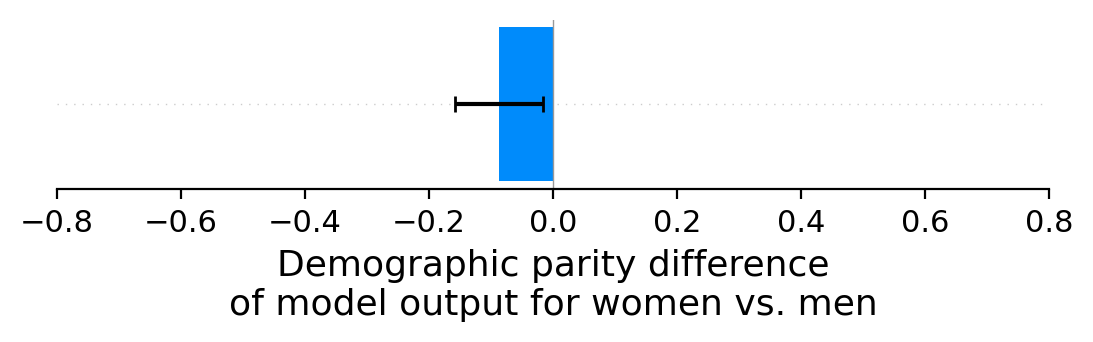

In [5]:
N = 10000
shap_values_A, sex_A, X_A, ev_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(
    shap_values_A.sum(1), sex_A, xmin=xmin, xmax=xmax, xlabel=glabel
)

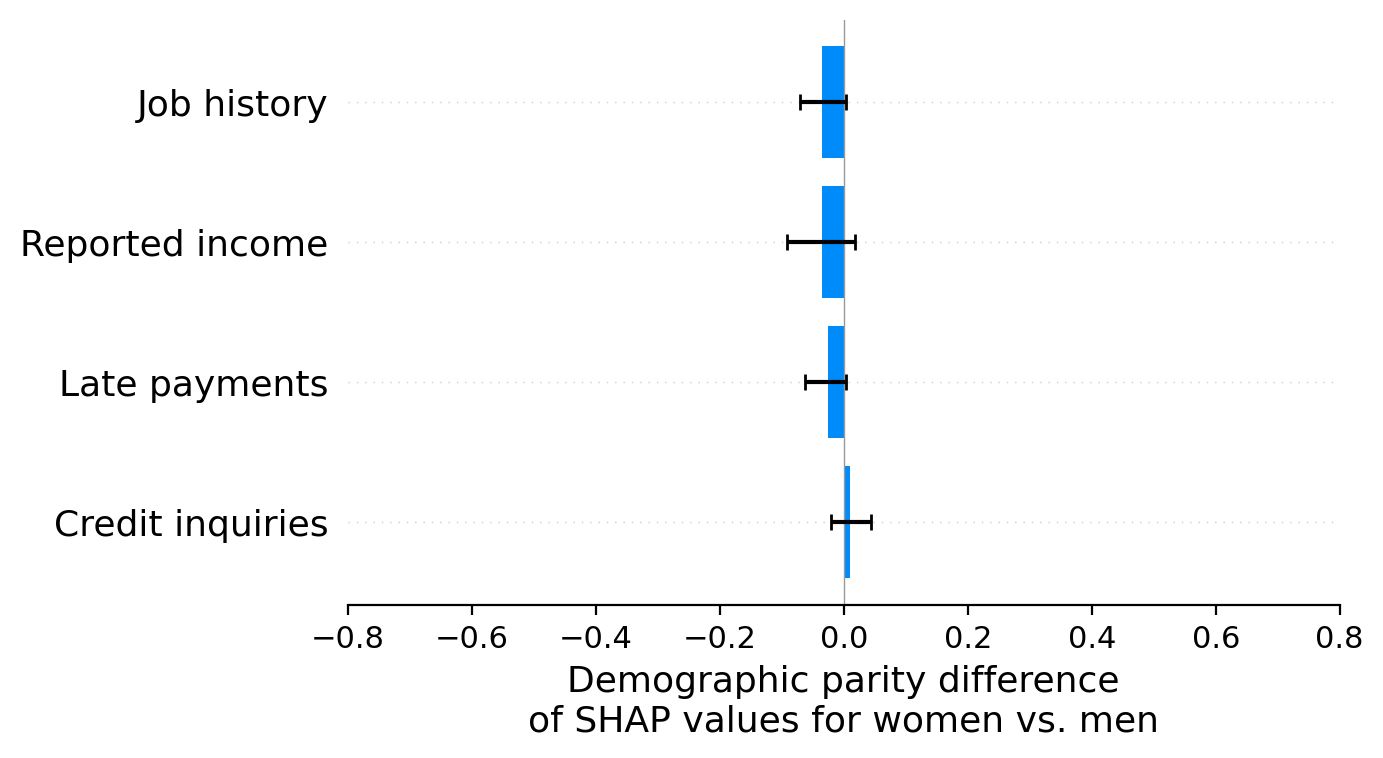

In [6]:
slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(
    shap_values_A, sex_A, X_A.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:06:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 97%|=================== | 9686/10000 [00:22<00:00]       FixedFormatter should only be used together with FixedLocator


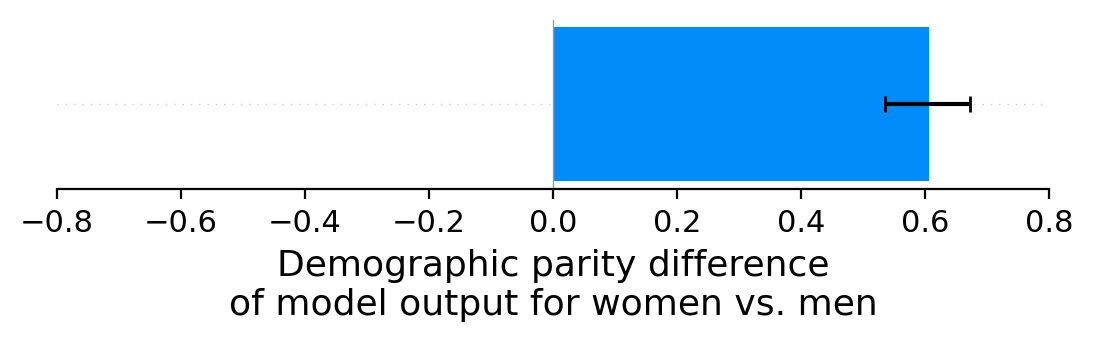

In [7]:
shap_values_B, sex_B, X_B, ev_B = run_credit_experiment(
    N, reported_income_sex_impact=30000
)
model_outputs_B = ev_B + shap_values_B.sum(1)
shap.group_difference_plot(
    shap_values_B.sum(1), sex_B, xmin=xmin, xmax=xmax, xlabel=glabel
)

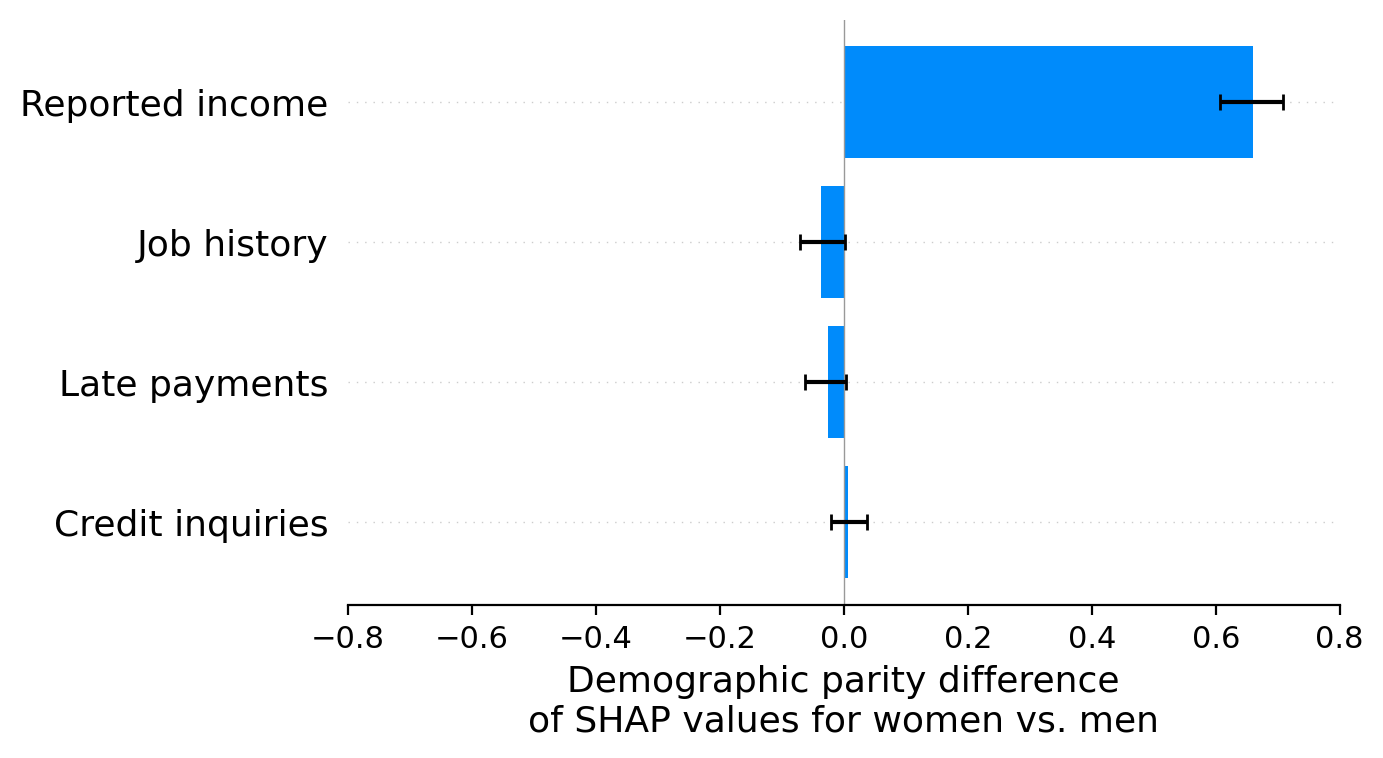

In [8]:
shap.group_difference_plot(
    shap_values_B, sex_B, X_B.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:36:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 9606/10000 [00:25<00:01]       FixedFormatter should only be used together with FixedLocator


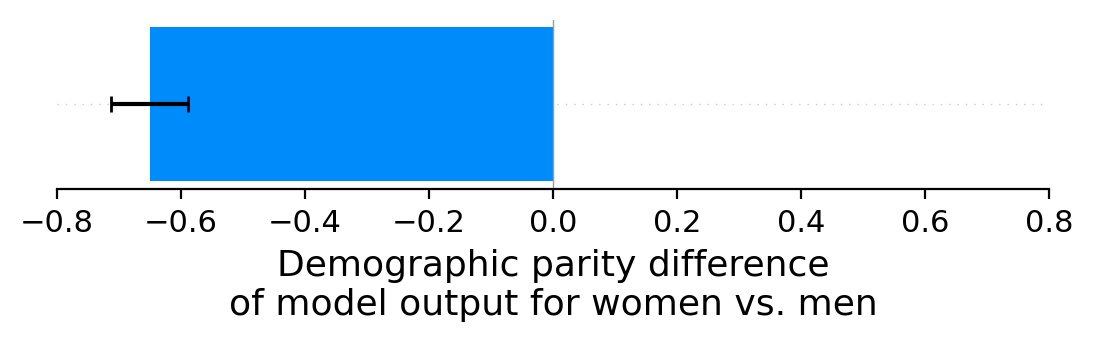

In [9]:
shap_values_C, sex_C, X_C, ev_C = run_credit_experiment(N, late_payments_sex_impact=2)
model_outputs_C = ev_C + shap_values_C.sum(1)
shap.group_difference_plot(
    shap_values_C.sum(1), sex_C, xmin=xmin, xmax=xmax, xlabel=glabel
)

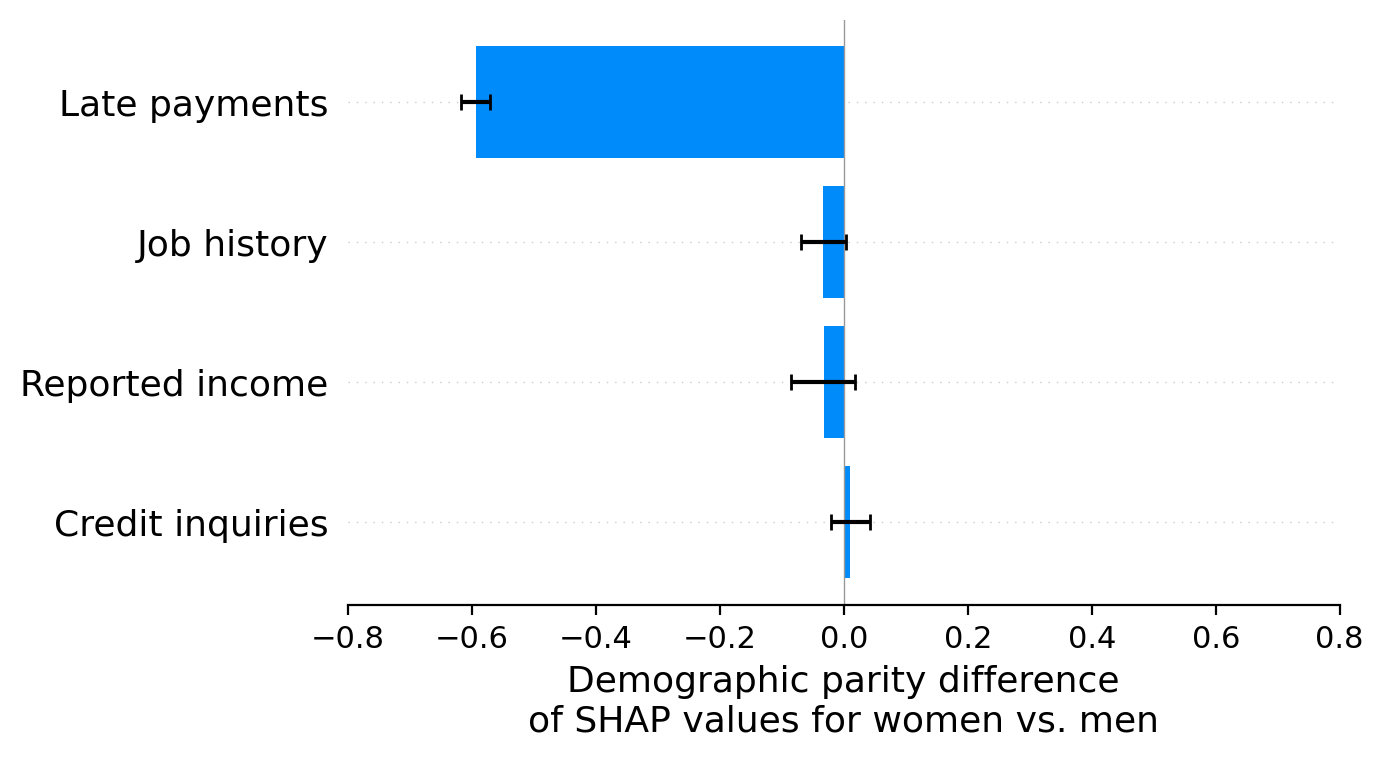

In [10]:
shap.group_difference_plot(
    shap_values_C, sex_C, X_C.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:37:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 97%|=================== | 9708/10000 [00:23<00:00]       FixedFormatter should only be used together with FixedLocator


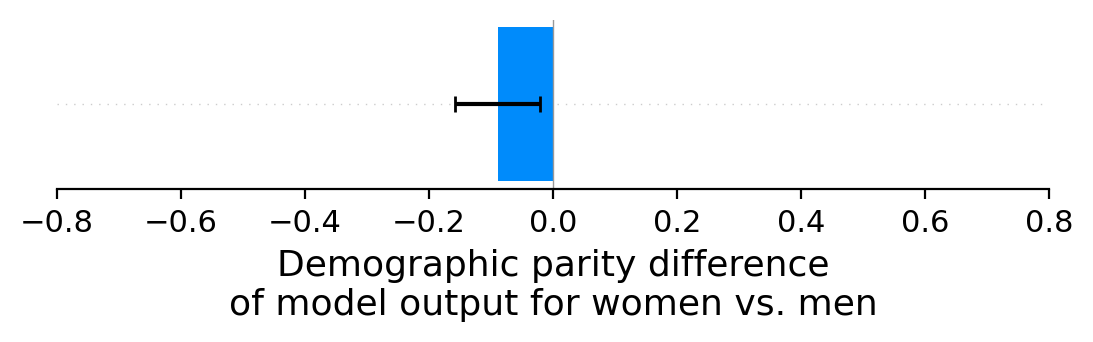

In [11]:
shap_values_D, sex_D, X_D, ev_D = run_credit_experiment(
    N, default_rate_sex_impact=-0.1
)  # 20% change
model_outputs_D = ev_D + shap_values_D.sum(1)
shap.group_difference_plot(
    shap_values_D.sum(1), sex_D, xmin=xmin, xmax=xmax, xlabel=glabel
)

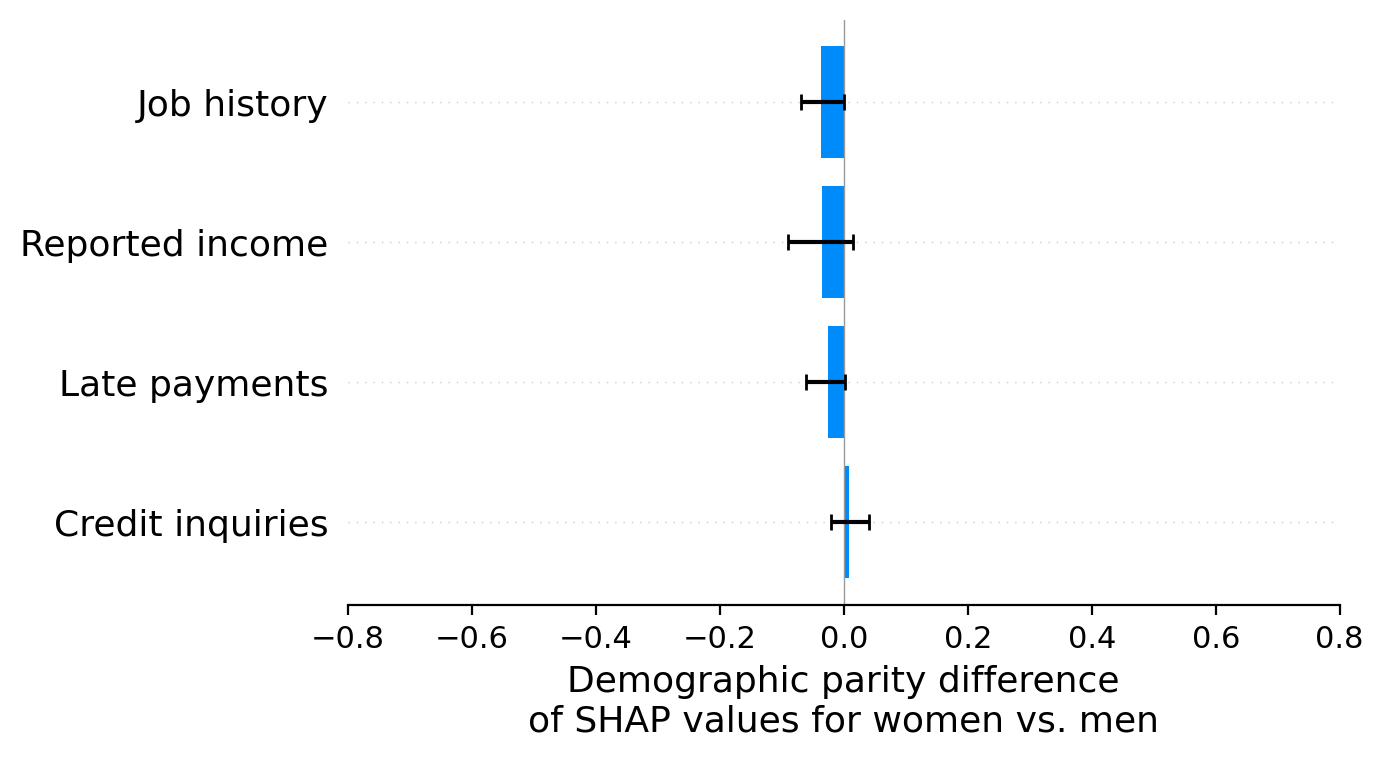

In [12]:
shap.group_difference_plot(
    shap_values_D, sex_D, X_D.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:38:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 9808/10000 [00:22<00:00]       FixedFormatter should only be used together with FixedLocator


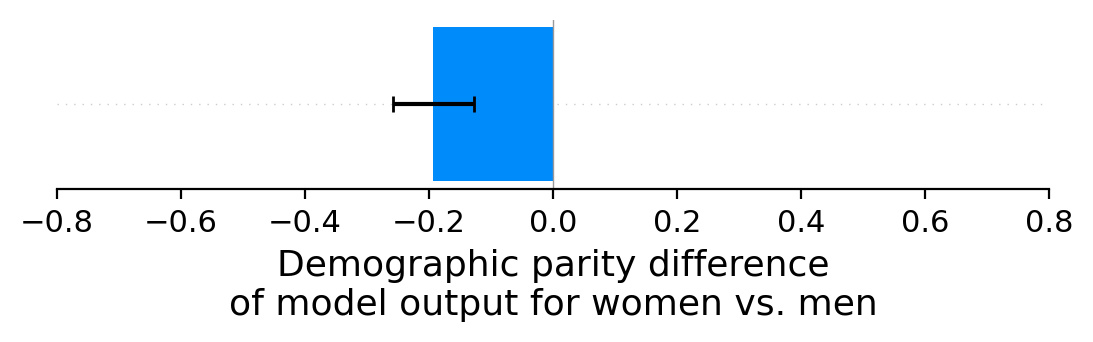

In [13]:
shap_values_E, sex_E, X_E, ev_E = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True
)
model_outputs_E = ev_E + shap_values_E.sum(1)
shap.group_difference_plot(
    shap_values_E.sum(1), sex_E, xmin=xmin, xmax=xmax, xlabel=glabel
)

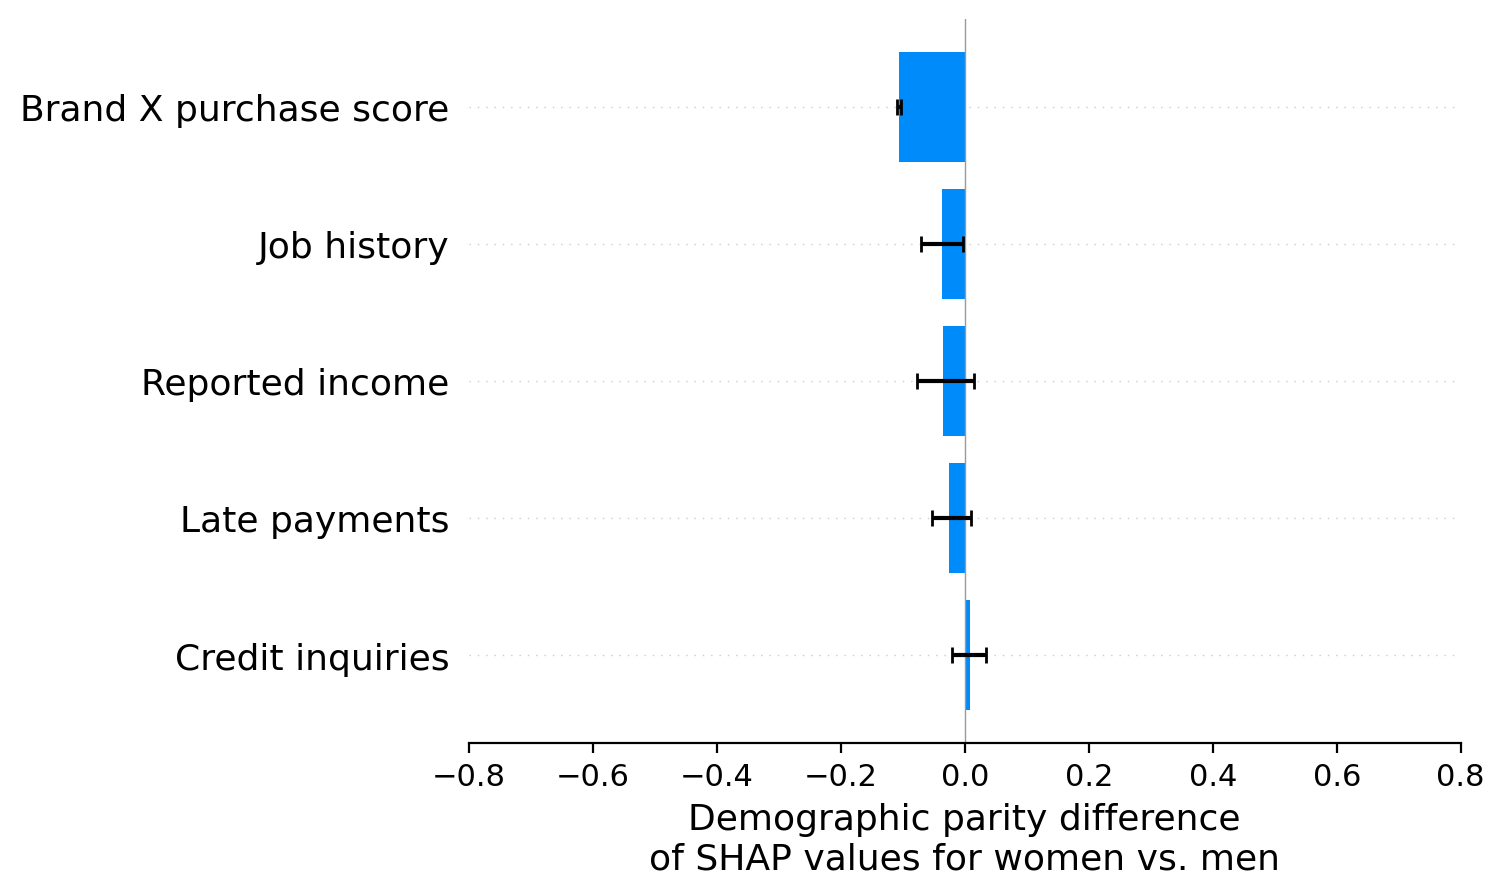

In [14]:
shap.group_difference_plot(
    shap_values_E, sex_E, X_E.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:40:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 95%|=================== | 9544/10000 [00:24<00:01]       FixedFormatter should only be used together with FixedLocator


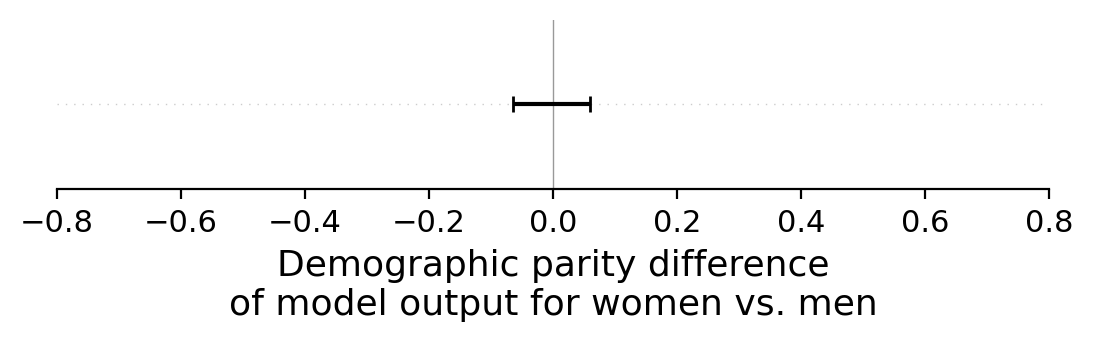

In [15]:
shap_values_F, sex_F, X_F, ev_F = run_credit_experiment(
    N,
    default_rate_sex_impact=-0.1,
    include_brandx_purchase_score=True,
    job_history_sex_impact=2,
)
model_outputs_F = ev_F + shap_values_F.sum(1)
shap.group_difference_plot(
    shap_values_F.sum(1), sex_F, xmin=xmin, xmax=xmax, xlabel=glabel
)

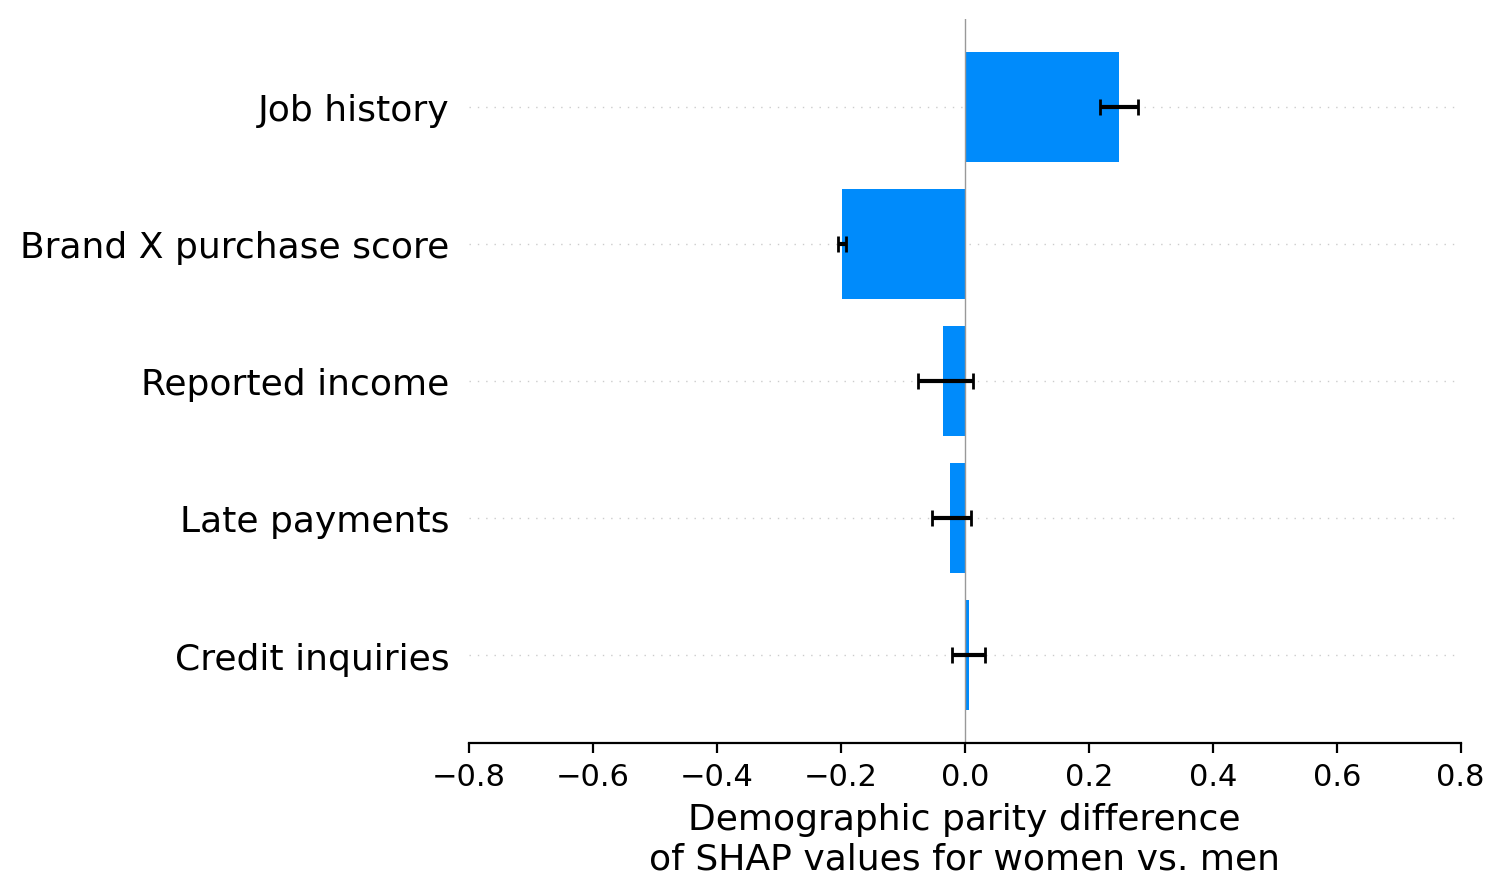

In [16]:
shap.group_difference_plot(
    shap_values_F, sex_F, X_F.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)

[18:41:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 9840/10000 [00:24<00:00]       FixedFormatter should only be used together with FixedLocator


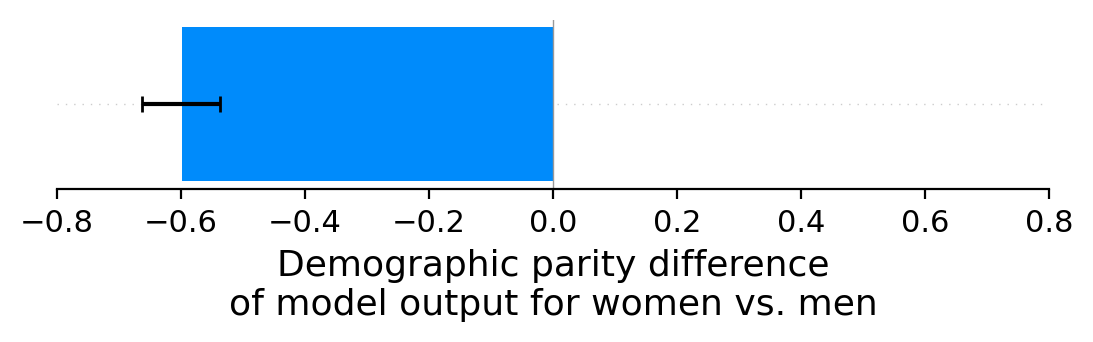

In [17]:
shap_values_G, sex_G, X_G, ev_G = run_credit_experiment(
    N,
    default_rate_sex_impact=-0.1,
    include_brandx_purchase_score=True,
    job_history_sex_impact=2,
    include_sex=True,
)
model_outputs_G = ev_G + shap_values_G.sum(1)
shap.group_difference_plot(
    shap_values_G.sum(1), sex_G, xmin=xmin, xmax=xmax, xlabel=glabel
)

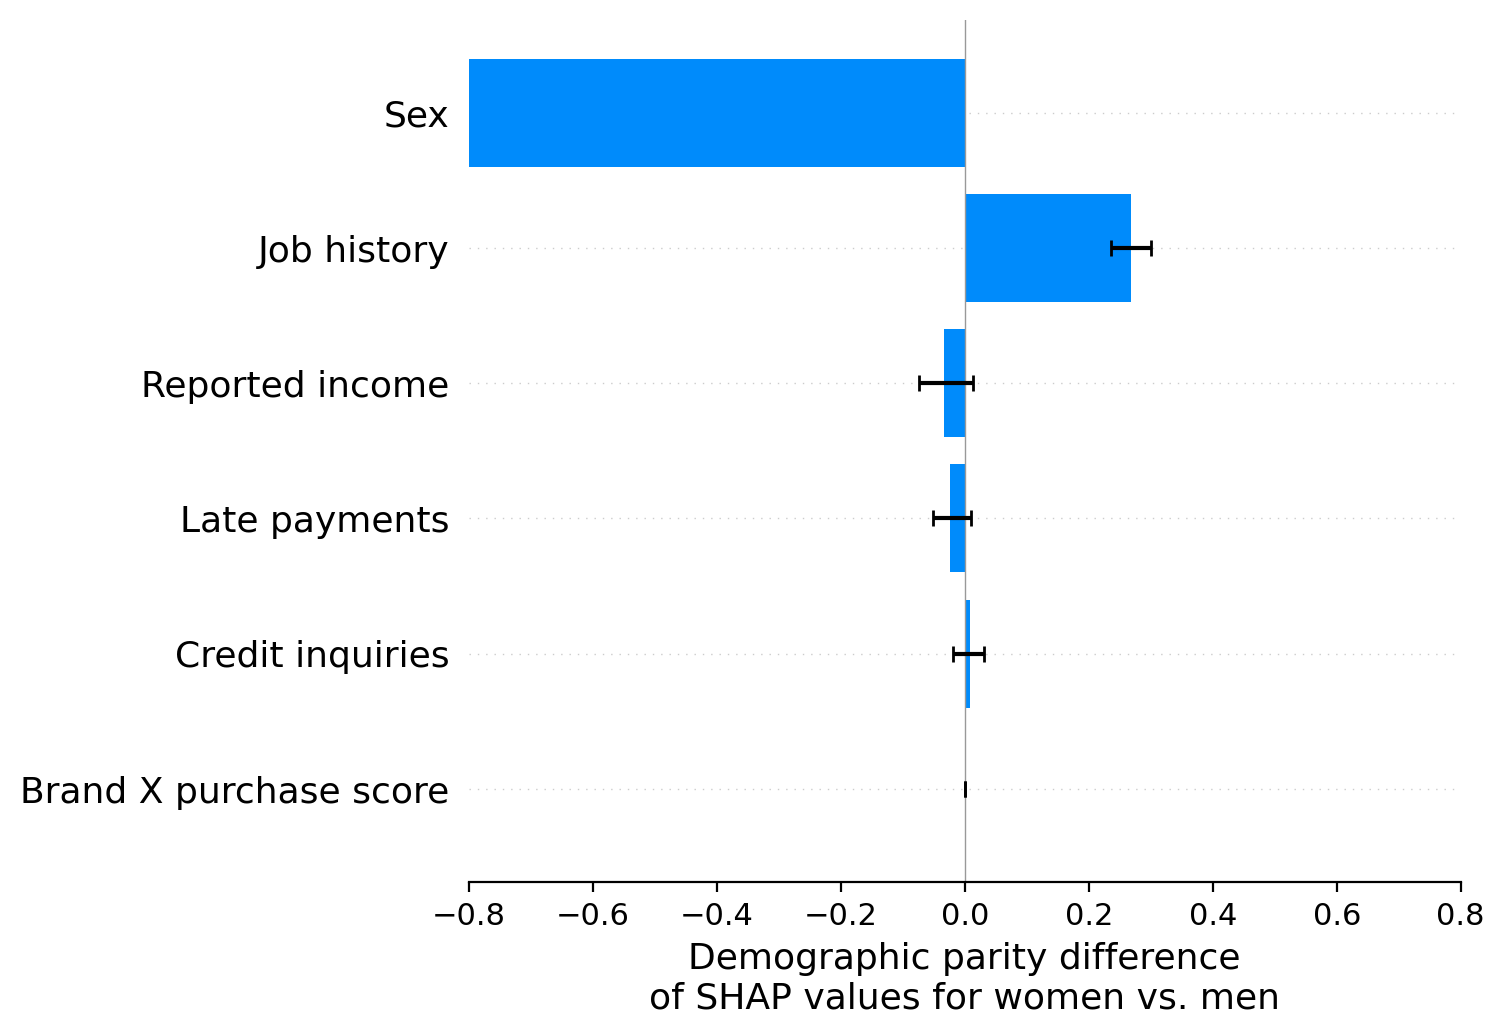

In [18]:
shap.group_difference_plot(
    shap_values_G, sex_G, X_G.columns, xmin=xmin, xmax=xmax, xlabel=slabel
)